In [1]:
import pandas as pd
import numpy as np

import datetime
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

import seaborn as sns
sns.set(rc={'figure.figsize':(24, 12)}, font_scale=2)
sns.set_style(style='whitegrid')

import math

from tqdm import tqdm

import sys
sys.path.append('../')
import utils
from pathlib import Path

In [2]:
def get_alerts_df(input_dir, mode):
    '''
    Return a list of the alert dataframes for the specified mode found under the `input_dir`
    '''
    alerts_df_list = []
    for dir in os.listdir(input_dir):
        alerts_df_path = input_dir + dir + '/evaluation/' + mode + '/alerts_df.pickle'
        if Path(alerts_df_path).is_file():
            alert_df = pd.read_pickle(input_dir + dir + '/evaluation/' + mode + '/alerts_df.pickle')
            alerts_df_list.append(alert_df)
        else:
            print(alerts_df_path, "Not Found")
    return alerts_df_list

# Streaming Variable Injected Region Length (12-48)

In [3]:
mode_to_mode_label = {
    'future_prediction_isj': 'ISJ',
    'future_prediction_fixed_bandwidth': 'Fixed',
    'future_prediction_isj_adj_local_min': 'ISJ + Adj. Local Min.',
    'mdi': 'MDI'
}

In [4]:
# Construct the alerts_dfs_dict
alerts_dfs_dict = {}
input_dir = '../streaming_data/synthetic_data/variable_inj_region_length/12_48/'
modes = ['future_prediction_isj', 'future_prediction_isj_adj_local_min']

eval_measures=['range_based_precision@k', 'range_based_recall@k', 'range_based_f1_score@k', 'range_based_precision@k_outlier_bounds', 'range_based_recall@k_outlier_bounds', 'range_based_f1_score@k_outlier_bounds']

for mode in modes:
    alerts_dfs_dict[mode] = get_alerts_df(input_dir, mode)

In [5]:
input_dir = '../streaming_data/synthetic_data/variable_inj_region_length/12_48/'

eval_df_columns = ['mode', 'seed', 'alert_num', 'Precision', 'Recall', 'F1 Score']
eval_df = pd.DataFrame(columns=eval_df_columns)

num_alerts=9
for seed in tqdm(sorted(os.listdir(input_dir))):
    for mode in os.listdir(input_dir + seed + '/evaluation/'):
        alerts_df = pd.read_pickle(input_dir + seed + '/evaluation/'+mode+'/alerts_df.pickle')
        
        for i in range(min(len(alerts_df.index), num_alerts)):
            precision, recall, f1_score = alerts_df.loc[i]['range_based_precision@k'], alerts_df.loc[i]['range_based_recall@k'], alerts_df.loc[i]['range_based_f1_score@k']
            eval_df.loc[len(eval_df.index)] = [mode_to_mode_label[mode], seed, i+1, precision, recall, f1_score]

            if mode != 'mdi':
                precision_outlier_bounds, recall_outlier_bounds, f1_score_outlier_bounds =  alerts_df.loc[i]['range_based_precision@k_outlier_bounds'], alerts_df.loc[i]['range_based_recall@k_outlier_bounds'], alerts_df.loc[i]['range_based_f1_score@k_outlier_bounds']
                eval_df.loc[len(eval_df.index)] = [mode_to_mode_label[mode] + ' + Outlier Bounds', seed, i+1, precision_outlier_bounds, recall_outlier_bounds, f1_score_outlier_bounds]
eval_df

100%|██████████| 10/10 [00:01<00:00,  8.81it/s]


,mode,seed,alert_num,Precision,Recall,F1 Score
0,MDI,seed_1,1,0.000000,0.000000,0.000000
1,MDI,seed_1,2,0.121951,0.319444,0.176516
2,MDI,seed_1,3,0.060976,0.159722,0.088258
3,MDI,seed_1,4,0.060976,0.159722,0.088258
4,MDI,seed_1,5,0.030488,0.079861,0.044129
...,...,...,...,...,...,...
546,ISJ + Outlier Bounds,seed_9,5,0.872562,0.670194,0.758106
547,ISJ,seed_9,6,0.550518,0.607155,0.577451
548,ISJ + Outlier Bounds,seed_9,6,0.882482,0.599380,0.713888
549,ISJ,seed_9,7,0.602489,0.827024,0.697123


In [6]:
modes_order=['Fixed', 'Fixed + Outlier Bounds', 'ISJ', 'ISJ + Outlier Bounds', 'ISJ + Adj. Local Min.', 'ISJ + Adj. Local Min. + Outlier Bounds', 'MDI']
eval_df['mode'] = pd.Categorical(eval_df['mode'], categories=modes_order)

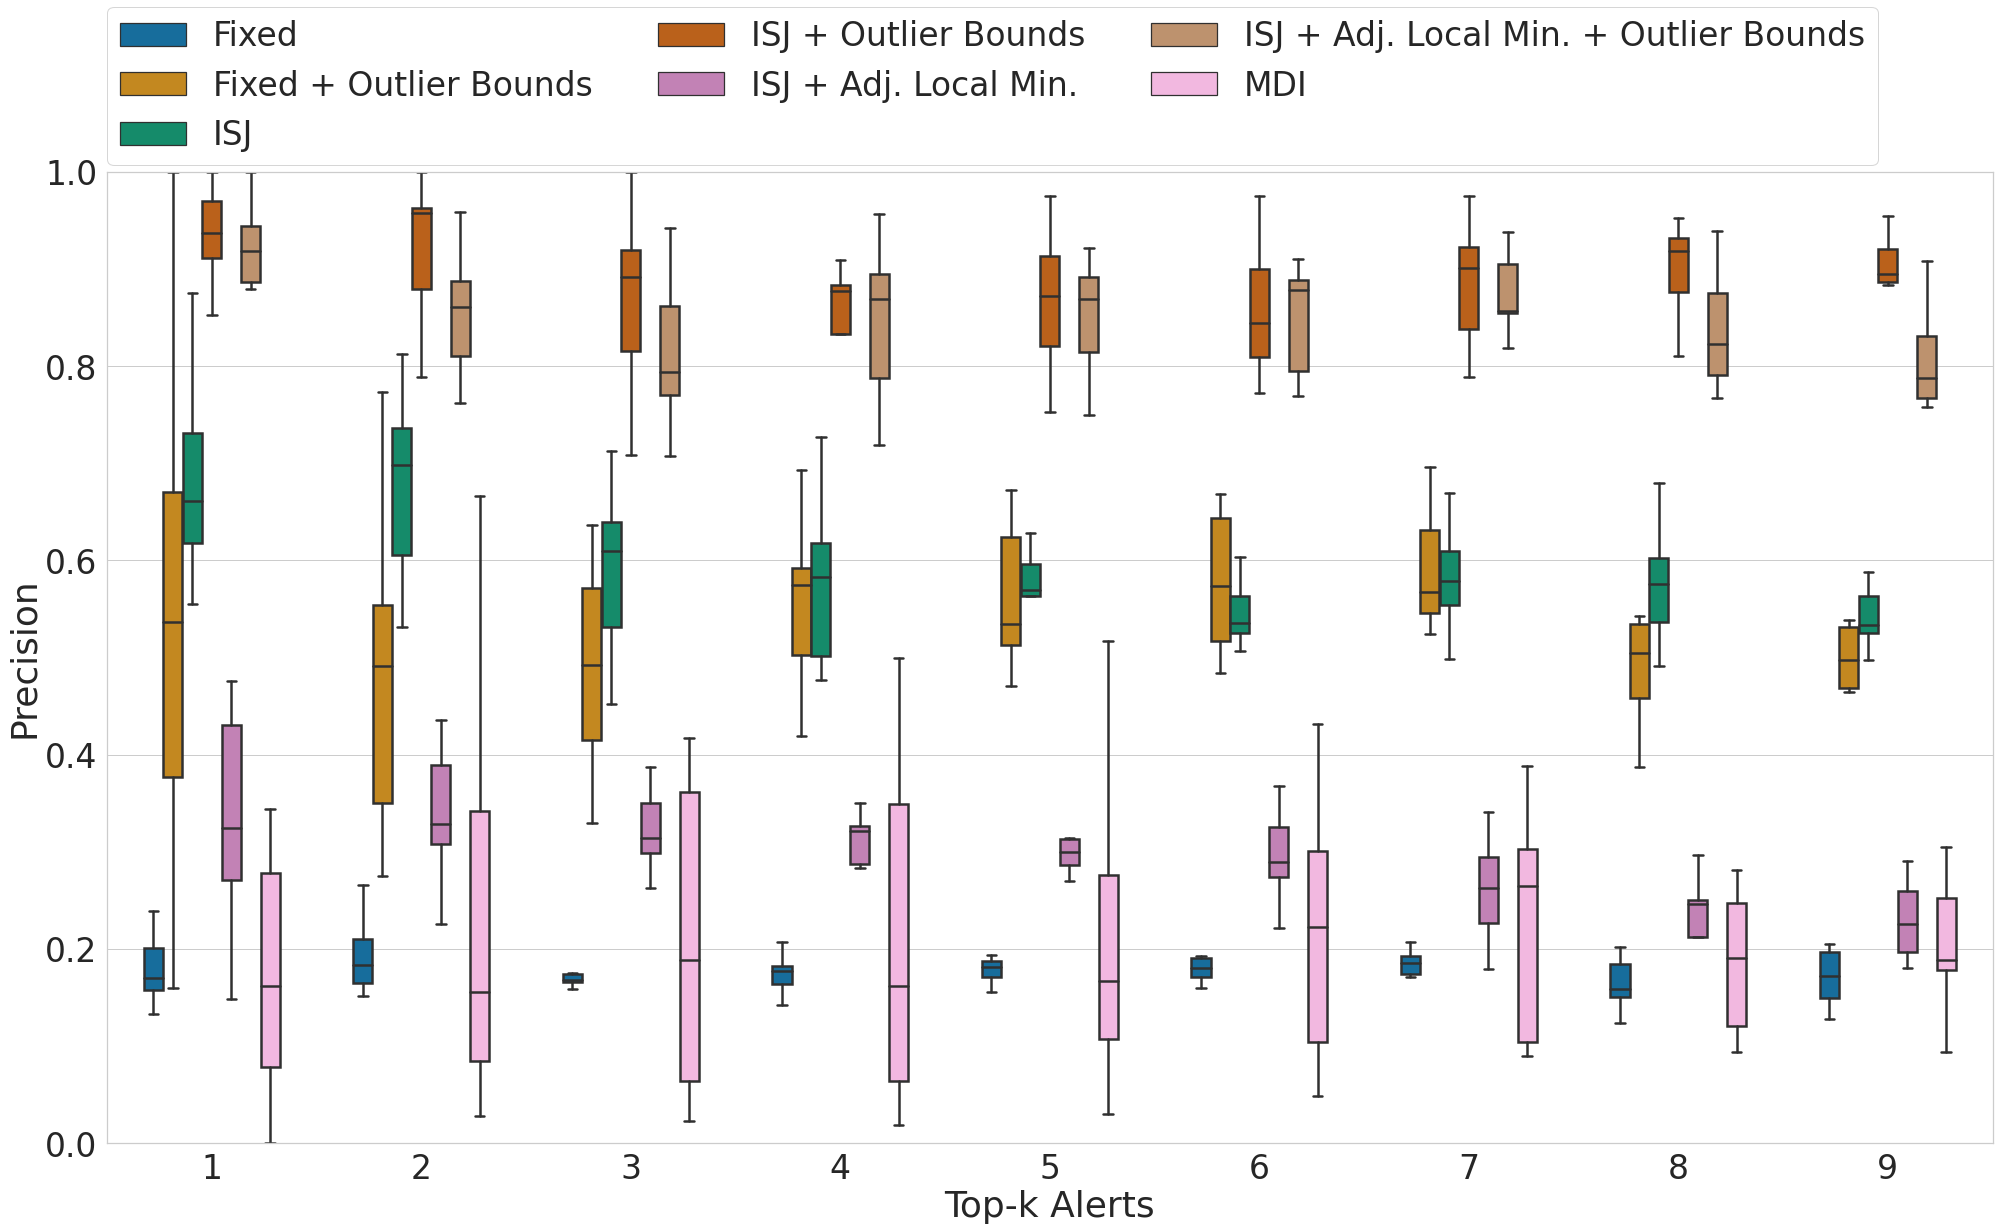

In [7]:
sns.set(rc={'figure.figsize':(30, 18)}, font_scale=3)
sns.set_style(style='whitegrid')
ax = sns.boxplot(x="alert_num", y="Precision", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.65, palette='colorblind')

plt.legend(bbox_to_anchor=(0, 1.17), loc=2, borderaxespad=0.,ncol=3)
plt.ylim(0,1);plt.xlabel("Top-k Alerts");plt.ylabel("Precision");plt.title("");plt.tight_layout()
plt.savefig('figures/experiments/synthetic/streaming/precision.svg')
plt.savefig('figures/experiments/synthetic/streaming/precision.pdf')

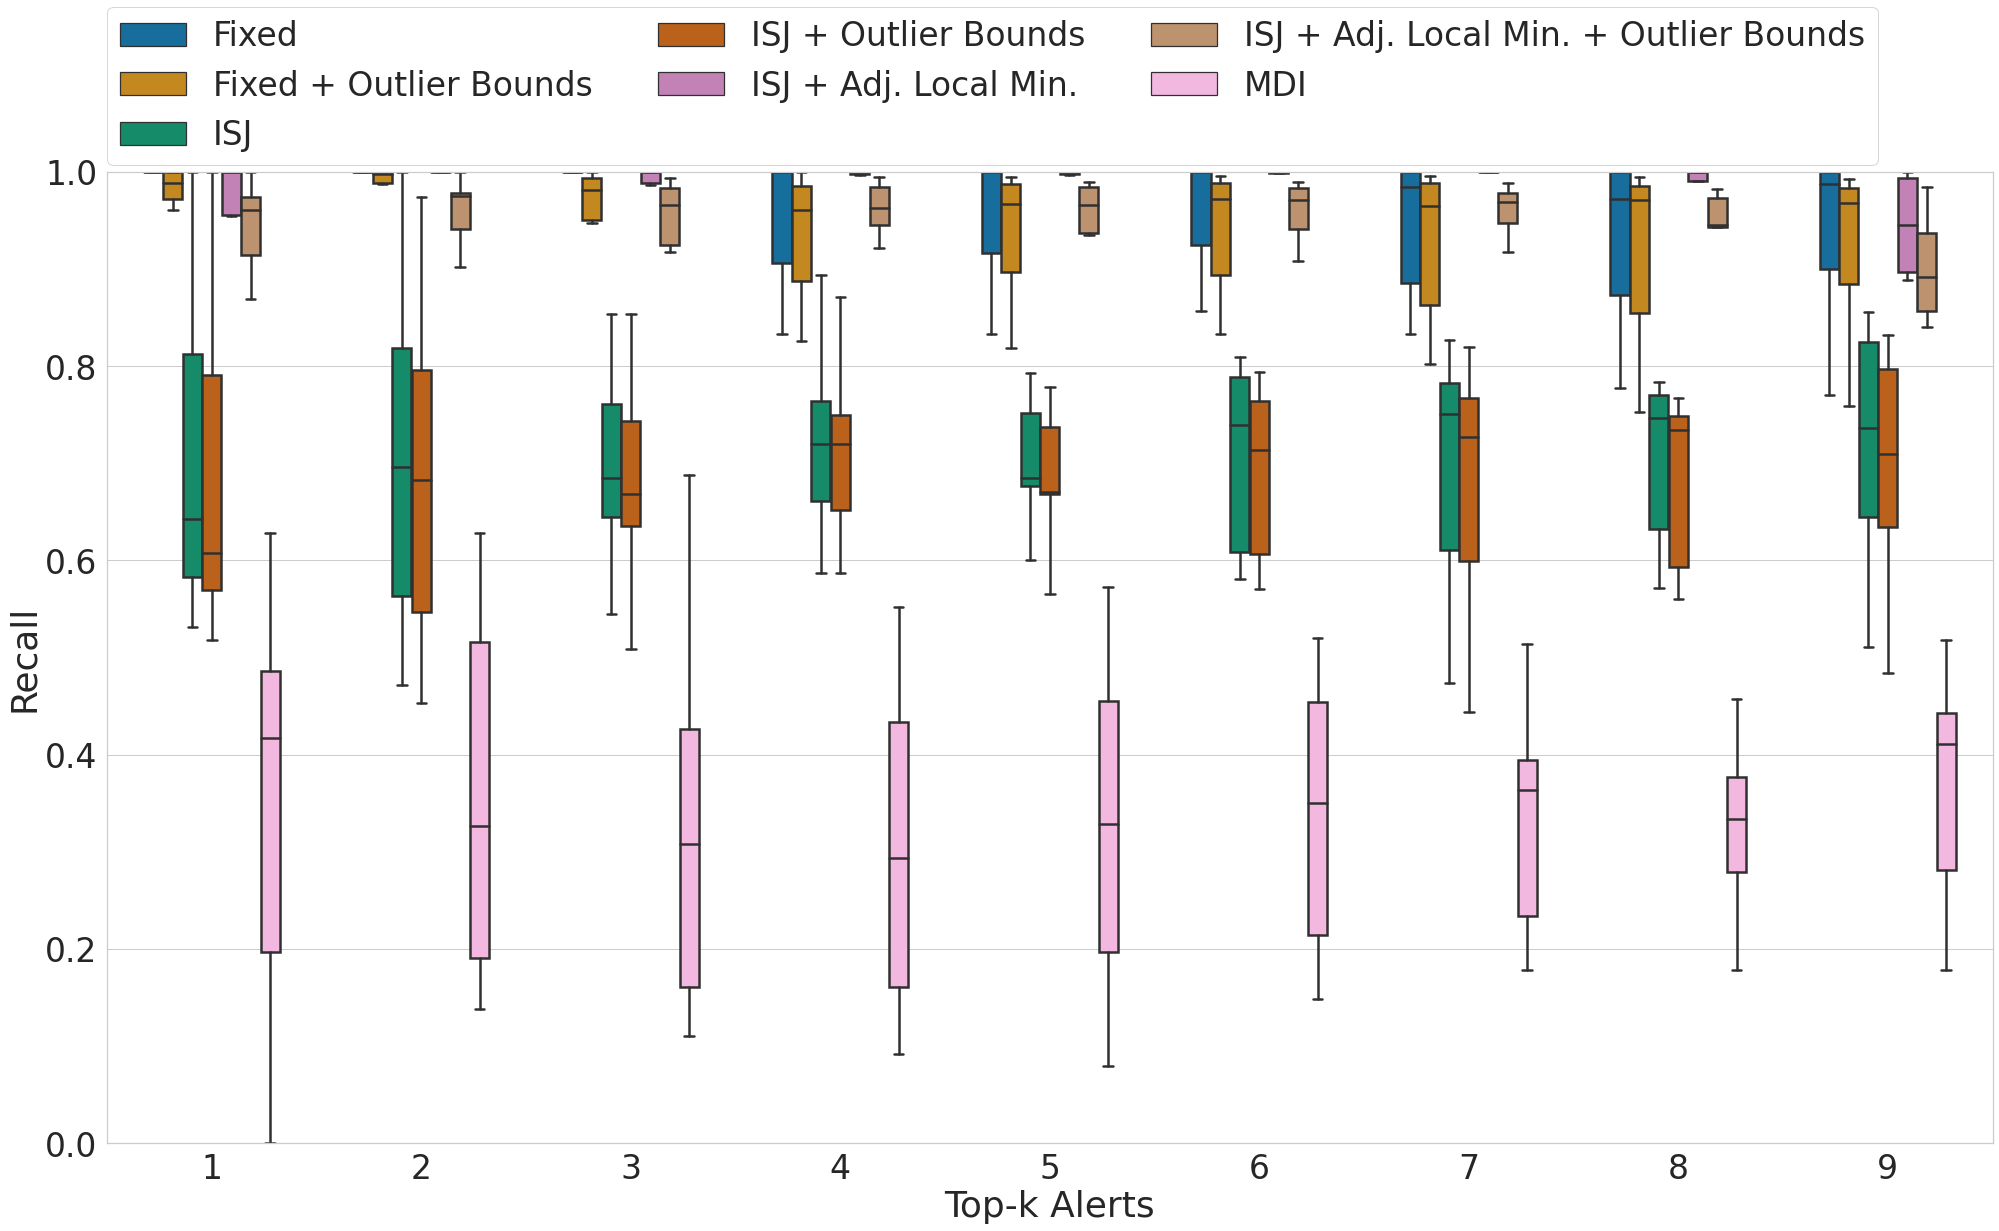

In [8]:
sns.set(rc={'figure.figsize':(30, 18)}, font_scale=3)
sns.set_style(style='whitegrid')
ax = sns.boxplot(x="alert_num", y="Recall", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.65, palette='colorblind')

plt.legend(bbox_to_anchor=(0, 1.17), loc=2, borderaxespad=0.,ncol=3)
plt.ylim(0,1);plt.xlabel("Top-k Alerts");plt.ylabel("Recall");plt.title("");plt.tight_layout()
plt.savefig('figures/experiments/synthetic/streaming/recall.svg')
plt.savefig('figures/experiments/synthetic/streaming/recall.pdf')

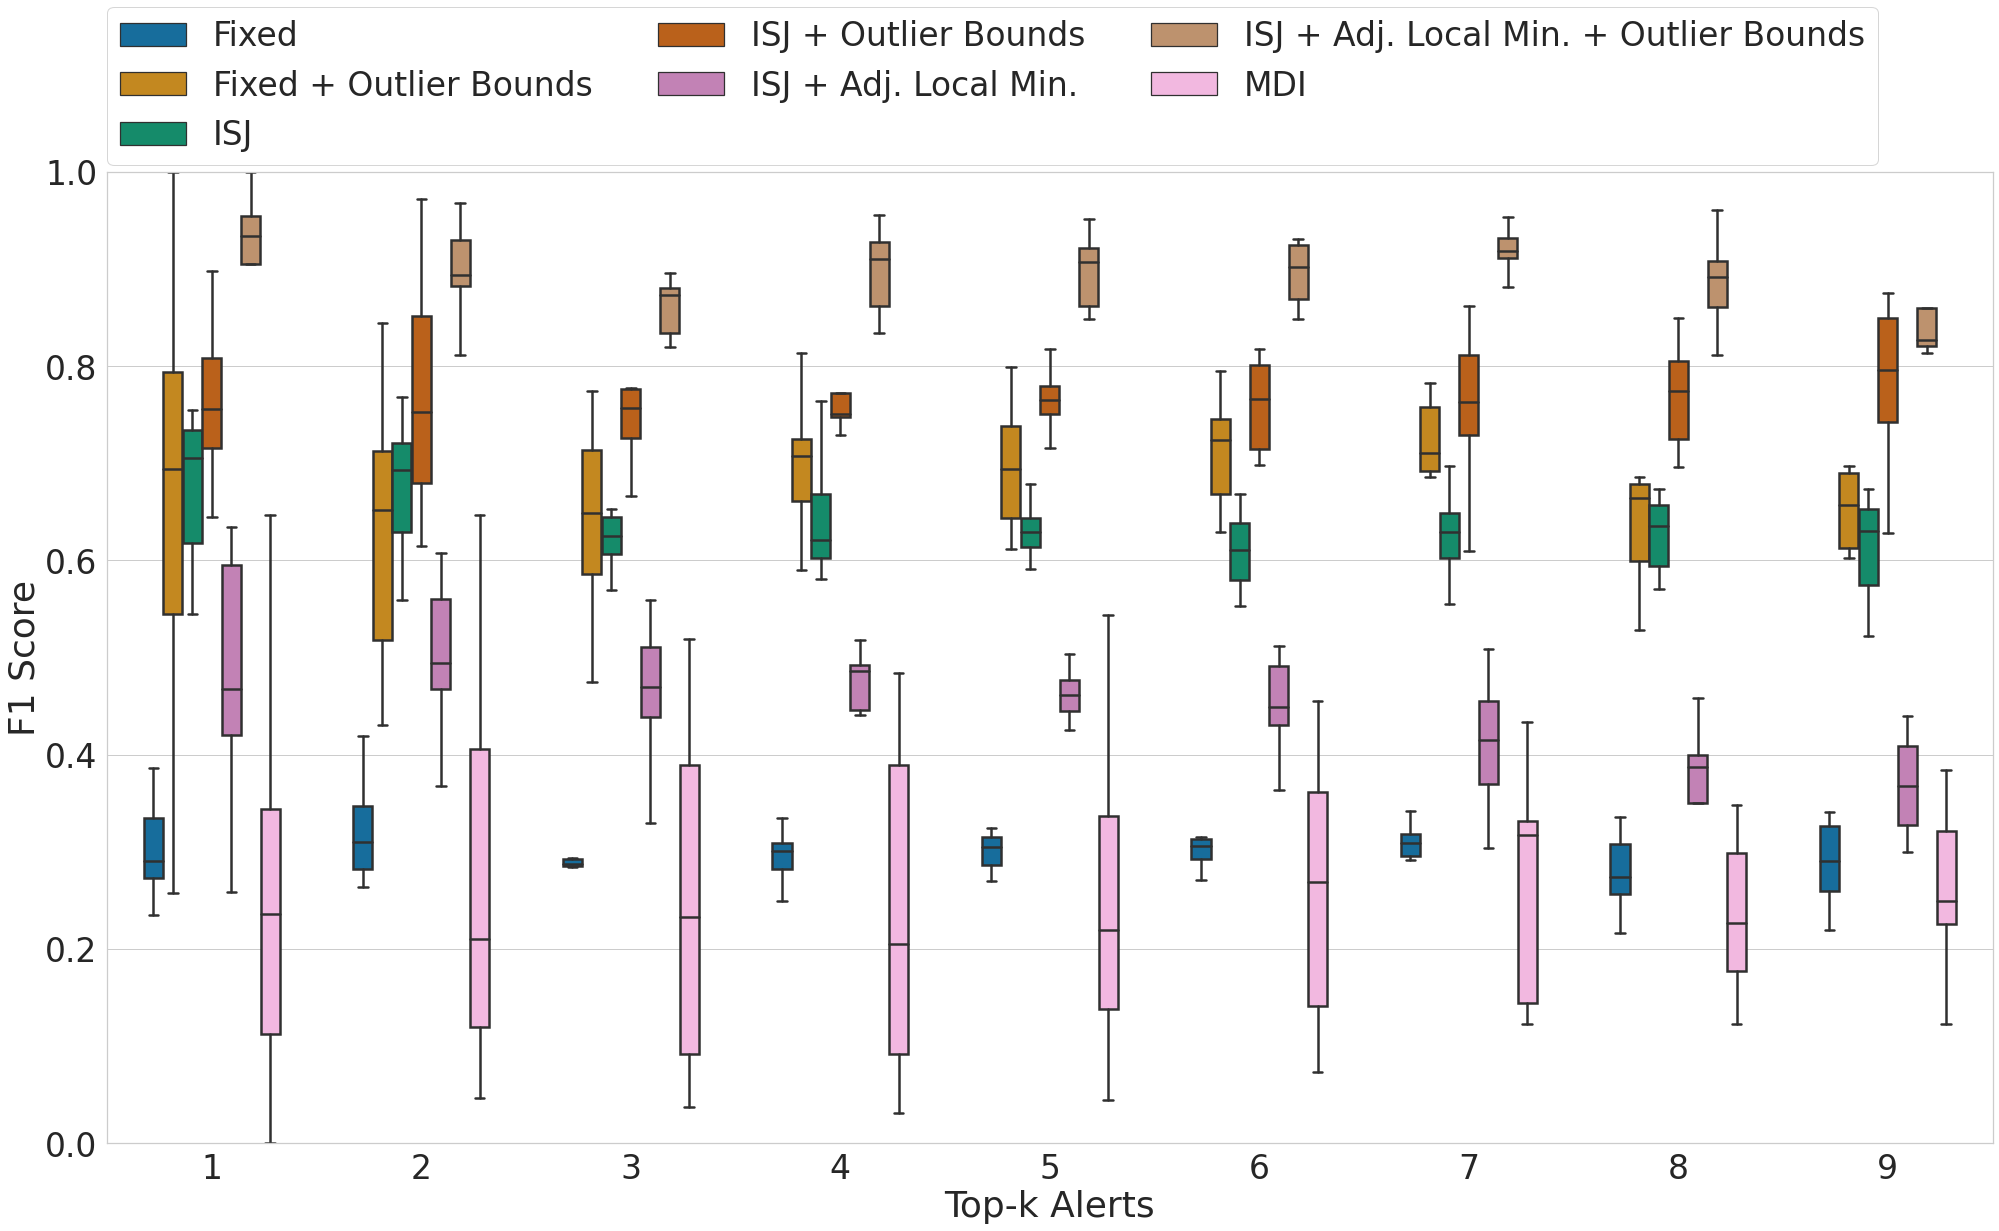

In [9]:
sns.set(rc={'figure.figsize':(30, 18)}, font_scale=3)
sns.set_style(style='whitegrid')
ax = sns.boxplot(x="alert_num", y="F1 Score", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.65, palette='colorblind')

plt.legend(bbox_to_anchor=(0, 1.17), loc=2, borderaxespad=0.,ncol=3)
plt.ylim(0,1);plt.xlabel("Top-k Alerts");plt.ylabel("F1 Score");plt.title("");plt.tight_layout()
plt.savefig('figures/experiments/synthetic/streaming/f1_score.svg')
plt.savefig('figures/experiments/synthetic/streaming/f1_score.pdf')

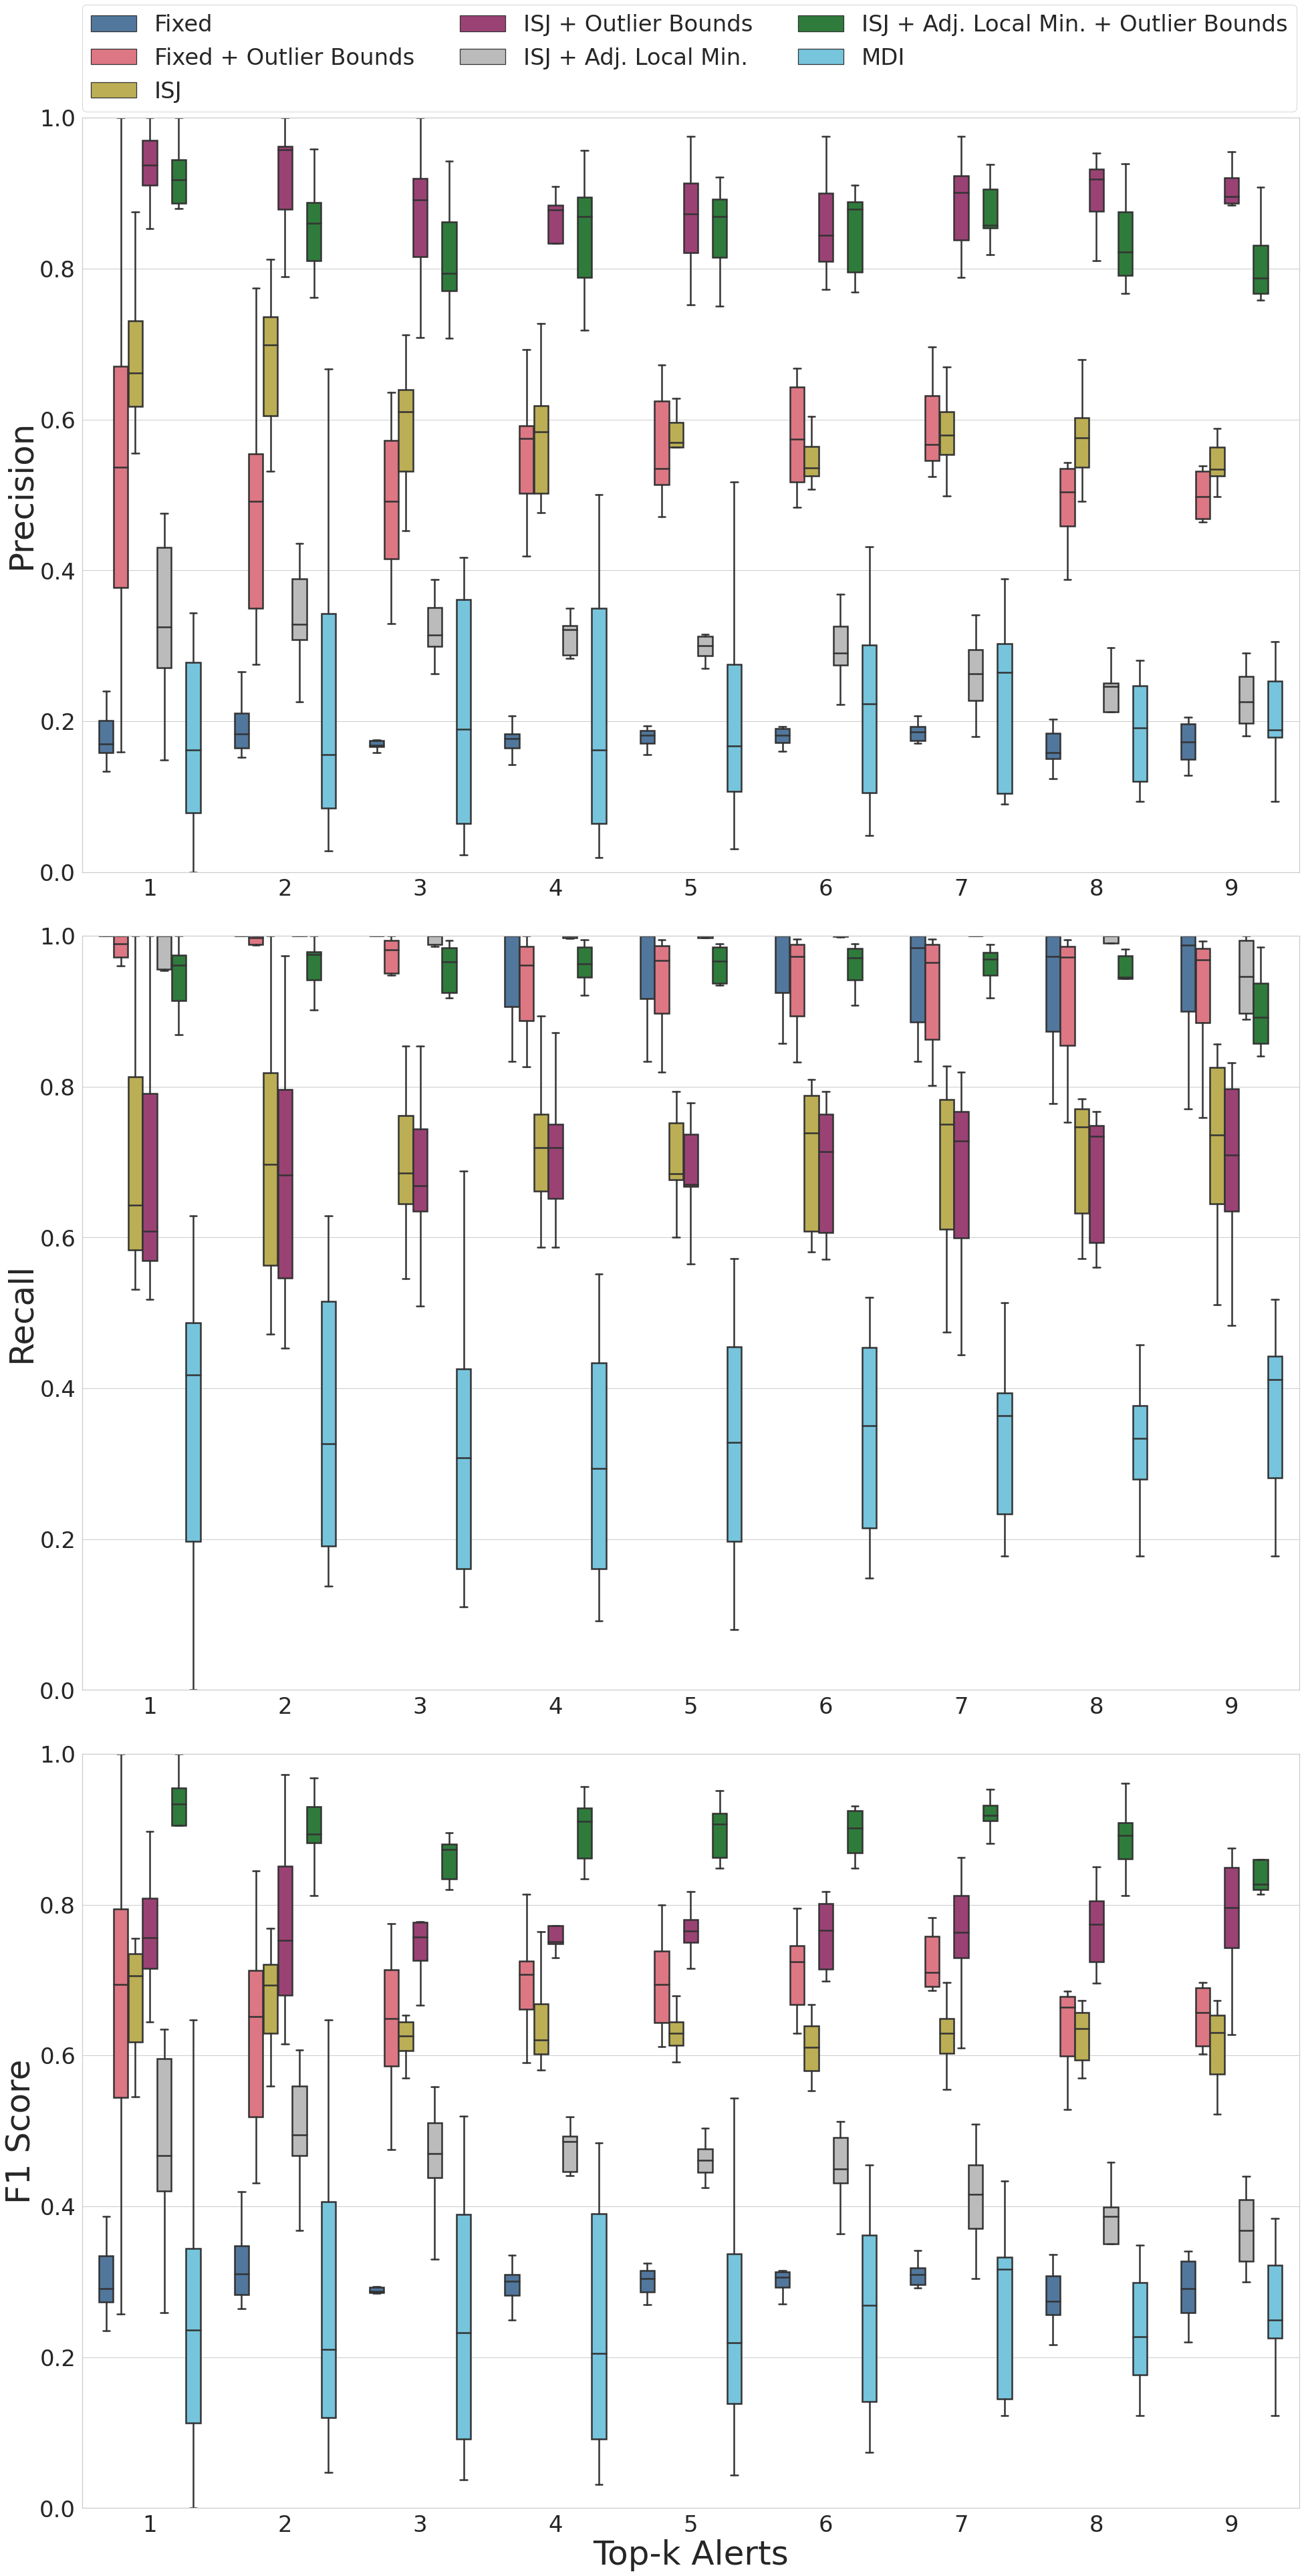

In [12]:
palette = ['#4477AA', '#EE6677', '#CCBB44', '#AA3377', '#BBBBBB', '#228833', '#66CCEE']

fig, axs = plt.subplots(3)
sns.set(rc={'figure.figsize':(30, 54)}, font_scale=3.08)
sns.set_style(style='whitegrid')

ax1 = sns.boxplot(ax=axs[0], x="alert_num", y="Precision", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette=sns.color_palette(palette, 7))
ax1.legend(bbox_to_anchor=(0, 1.15), loc=2, borderaxespad=0.,ncol=3)
ax1.set_xlabel('');ax1.set_ylim(0,1);ax1.set_ylabel('Precision', fontsize=50)

ax2 = sns.boxplot(ax=axs[1], x="alert_num", y="Recall", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette=sns.color_palette(palette, 7))
ax2.legend().remove();ax2.set_xlabel('');ax2.set_ylim(0,1);ax2.set_ylabel('Recall', fontsize=50)

ax3 = sns.boxplot(ax=axs[2], x="alert_num", y="F1 Score", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette=sns.color_palette(palette, 7))
ax3.legend().remove();ax3.set_xlabel("Top-k Alerts", fontsize=50);ax3.set_ylim(0,1);ax3.set_ylabel('F1 Score', fontsize=50)

fig.subplots_adjust(hspace=0.1);plt.tight_layout()
plt.savefig('figures/experiments/synthetic/streaming/top_k_alerts_all.svg')
plt.savefig('figures/experiments/synthetic/streaming/top_k_alerts_all.pdf')